In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

import torch
import torchvision
from torchvision import transforms

In [38]:
train_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/data', train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/data', train=False, transform=transforms.ToTensor())

In [14]:
np.array(train_dataset[0][0]).shape

(1, 28, 28)

In [25]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

classes = [str(i) for i in range(10)]

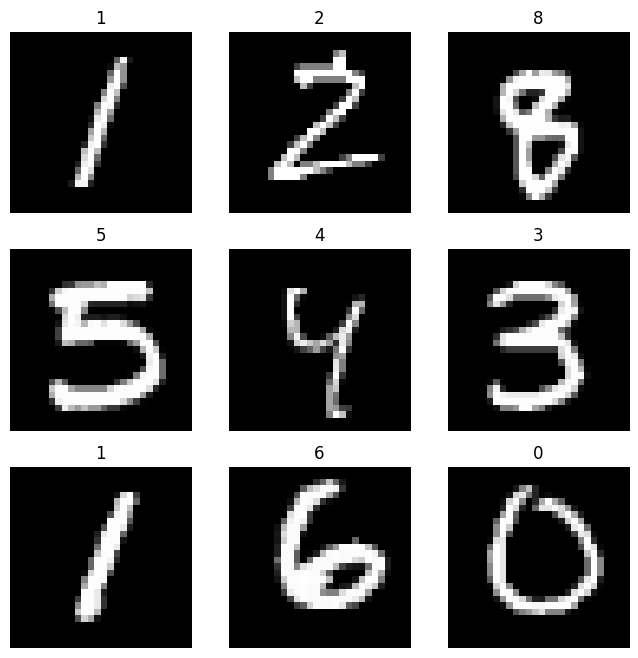

In [42]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # Lấy index ngẫu nhiên
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    # Lấy dữ liệu ngẫu nhiên bằng index
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    # Vẽ ảnh
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [41]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnn_layers = torch.nn.Sequential(
        # Convolutional Layer. 64 filter
        torch.nn.Conv2d(1, 64, kernel_size=5, stride=1, padding="valid"),
        # Relu layer sau convolution
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 128, kernel_size=3, padding="valid"),
        torch.nn.ReLU(),
        # Bỏ bớt 10% output từ filter layer trước
        torch.nn.Dropout2d(0.1),
        # Max pooling 2x2
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(128, 256, kernel_size=3, padding="valid"),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.1),
        torch.nn.MaxPool2d(3),
        # Từ kết quả neuron phân bố 2D thành 1D
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        # Bắt đầu layer Fully Connected của Neural Network bình thường
        torch.nn.LazyLinear(),
        torch.nn.ReLU(),
        # Bỏ 10% neuron ngẫu nhiên.
        torch.nn.Dropout(0.1),
        torch.nn.LazyLinear(),
        # Layer output dự đoán ảnh thuộc label nào
        torch.nn.Softmax()
    )
    def forward(self, X):
        # Chạy toàn bộ layer
        result = self.cnn_layers(X)
        return result

In [20]:
cnn = CNN()
cnn = cnn.to(device)

In [21]:
# Hàm lấy sai số và hàm tối ưu
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=0.001, weight_decay=0.001)

In [22]:
# 1 epoch là 1 lần model train toàn bộ dữ liệu
epochs = 6

for epoch in range(1, epochs + 1):
    correct = 0
    total_loss = 0
    # Từ Dataloader định nghĩa ở trên, ta sẽ lấy 32 ảnh và 32 labels.
    for X, y in train_dataloader:
        # Chuyển dữ liệu này cho GPU hoặc CPU
        # X là ảnh, y là label
        X = X.to(device)
        y = y.to(device)

        # Thử đưa 32 ảnh cho model CNN để dự đoán
        # Kết quả là cho mỗi ảnh có 10 xác xuất (tương ứng với 10 labels), xác xuất càng cao thì model càng chắc chắn về dự đoán
        pred_y = cnn(X)
        # Tính Cross Entropy Loss dựa vào độ sai lệch giữa dự đoán và label thật.
        loss = loss_fn(pred_y, y)

        # Phải cố tình cho gradient về 0, nếu không gradient sẽ tích trữ và học sai
        optimizer.zero_grad()
        # Back propagation: model tìm gradient để sửa lỗi
        loss.backward()
        # Sửa lại lỗi bằng cách update lại weight với gradient
        optimizer.step()

        # Ta sử dụng argmax để lấy index của chữ cái nào có xác xuất lớn nhất trong 10 chữ cái
        processed_pred_y = torch.argmax(pred_y, dim=1)
        correct += (processed_pred_y == y).float().sum()

    total_loss += loss
    # Tính độ chính xác của dự đoán so với label thực tế
    accuracy = 100 * correct / len(train_dataset)
    # In loss và độ chính xác cho mỗi epoch
    print(f"Epoch: {epoch}, loss: {total_loss}, accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, loss: 1.54558527469635, accuracy: 90.86%
Epoch: 2, loss: 1.613467812538147, accuracy: 96.71%
Epoch: 3, loss: 1.4615898132324219, accuracy: 97.14%
Epoch: 4, loss: 1.4632034301757812, accuracy: 97.29%
Epoch: 5, loss: 1.493854284286499, accuracy: 97.50%
Epoch: 6, loss: 1.4855746030807495, accuracy: 97.44%


In [23]:
def test(dataloader, model):
    correct_preds = 0
    total = 0
    for batch_index, (X, y) in enumerate(dataloader):
        # Chuyển dữ liệu ảnh và label đến GPU hoặc CPU
        X = X.to(device)
        y = y.to(device)
        # Cho model dự đoán
        predictions = model(X)
        processed_preds = torch.argmax(predictions, dim=1)
        correct_preds += torch.sum(processed_preds==y).item()
        total += X.shape[0]

    accuracy = correct_preds/total
    print(f"{accuracy*100:.5f}%")

In [24]:
test(test_dataloader, cnn)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


97.86000%


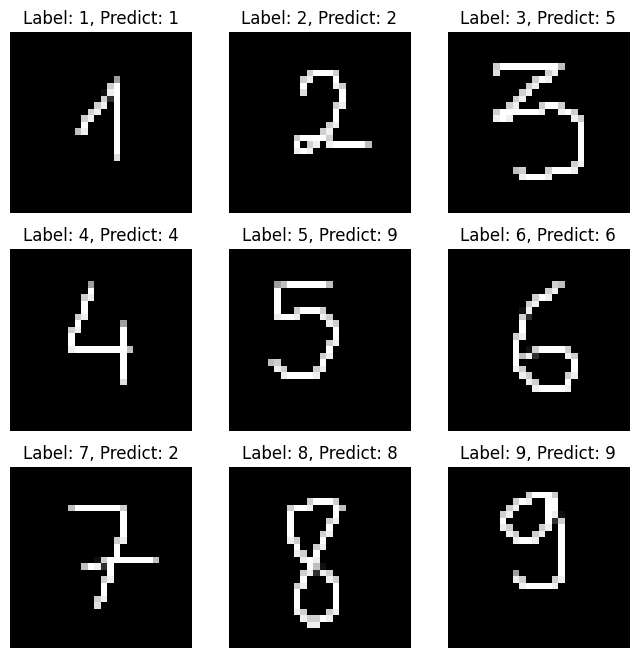

In [36]:
i = 1
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
while os.path.exists(f"/content/data_test/{i}.png"):
  img = cv2.imread(f"/content/data_test/{i}.png", cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (28, 28))
  img = img.reshape(1, 1, 28, 28)
  img = np.invert(img)
  plt.subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  img = torch.tensor(img, dtype=torch.float32)
  img = img.to(device)
  pred = cnn(img)
  pred = torch.argmax(pred, dim=1)
  plt.title(f"Label: {i}, Predict: {pred.item()}")
  plt.axis("off")
  i+=1

In [37]:
# Save model
torch.save(cnn.state_dict(), 'model.pth')